## Librerías

In [5]:
import open3d as o3d
import numpy as np
import pandas as pd
import os
import re
from glob import glob
import time
import random
import seaborn as sns
import xml.etree.ElementTree as ET
from mpl_toolkits.mplot3d import Axes3D
from pyntcloud import PyntCloud
import plotly.graph_objs as go
from matplotlib.pyplot import cm
import matplotlib.pyplot as plt 
from plotly.offline import iplot, init_notebook_mode

from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


import warnings
warnings.filterwarnings("ignore")

init_notebook_mode(connected=True)
%matplotlib inline

## DataLoader

In [ ]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from scipy.spatial import cKDTree

category_mapping_2 = {
    0: [43, 38, 58, 29, 41, 42, 44, 39, 55], # Construction
    1: [4, 45, 6, 40, 60, 61, 33, 32, 14], # Object
    2: [7, 22, 9, 26, 11, 21], # Road
    3: [48, 47, 1, 19, 46, 10, 25], # Sign
    4: [23, 3, 24, 31, 2], # Terrain  
    5: [51, 50, 5, 18], # Drivable Vegetation
    6: [28, 27, 62, 52, 16, 30, 59, 17], # Non Drivable Vegetation
    7: [13, 15, 12, 36, 57, 49, 20, 35, 37, 34, 63], # Vehicle
    8: [8, 56, 0, 53, 54], # Void
}

category_mapping_2 = {
    0: [12],               # Construction: building
    1: [9,15,17,18,27],    # Object
    2: [10],               # Road
    3: [5],                # Sign
    4: [1,23,33,34],       # Terrain: dirt, concrete, mud, rubble
    5: [3],                # Drivable Vegetation
    6: [4,19],             # Non Drivable Vegetation
    7: [8],                # Vehicle
    8: [6,7,31],           # Void
}

category_mapping_2 = {
    0: [12],                                 # Construction
    1: [9,15,17,18,27,34],                   # Object
    2: [10],                                 # Road
    3: [5],                                  # Sign
    4: [1,23,31,33],                         # Terrain
    5: [3],                                  # Drivable Vegetation
    6: [4,19],                               # Non Drivable Vegetation
    7: [8],                                  # Vehicle
    8: [0,6,7],                              # Void
}

# Generar el diccionario inverso para mapear etiquetas
label_to_category = {label: cat for cat, labels in category_mapping_2.items() for label in labels}

# Función para remapear etiquetas
def map_labels(labels: np.ndarray) -> np.ndarray:
    return np.array([label_to_category.get(label, 8) for label in labels], dtype=np.uint8)

def load_bin_file(bin_path: str, num_points: int, radius: float = 25.0, seed: int = None):
    full_points = np.fromfile(bin_path, dtype=np.float32).reshape(-1, 4)
    points = full_points[:, :3]
    remission = full_points[:, 3]  # Añadir remission (shape: [N, 1])

    distances = np.linalg.norm(points, axis=1)
    mask = distances <= radius
    points = points[mask]
    remission = remission[mask]  # Filtrar remission también
    num_available = points.shape[0]

    if num_available >= num_points:
        if seed is not None:
            np.random.seed(seed)  # Establece semilla si se proporciona
        indices = np.random.choice(num_available, num_points, replace=False)
        return points[indices], remission[indices], np.where(mask)[0][indices]

    return None, None, None

def load_label_file(label_path: str, indices: np.ndarray) -> np.ndarray:
    labels = np.fromfile(label_path, dtype=np.uint32) & 0xFFFF
    return map_labels(labels[indices])

def normalize_point_cloud(points):
    mean = np.mean(points, axis=0)  # Media por dimensión
    std = np.std(points, axis=0) + 1e-6  # Evitar divisiones por 0
    return (points - mean) / std

class GOOSEDataset(Dataset):
    def __init__(self, x_path, y_path, num_points=4096, mode='train', batch_size=32):
        self.x_files = sorted([os.path.join(x_path, f) for f in os.listdir(x_path) if f.endswith(".bin")])
        self.y_files = sorted([os.path.join(y_path, f) for f in os.listdir(y_path) if f.endswith(".label")])
        assert len(self.x_files) == len(self.y_files), "Número de archivos de entrada y etiquetas no coinciden"
        self.num_points = num_points
        self.batch_size = batch_size
        self.mode = mode

    def __len__(self):
        return len(self.x_files)

    def __getitem__(self, idx):
        seed = 42 if self.mode == 'val' else None  # Semilla fija para validación
        
        points, remission, indices = load_bin_file(self.x_files[idx], self.num_points, radius=25.0, seed=seed)

        if points is None or indices is None:
            return self.__getitem__((idx + 1) % len(self.x_files))
        
        labels = load_label_file(self.y_files[idx], indices)

        if labels is None:
            return self.__getitem__((idx + 1) % len(self.x_files))

        return torch.tensor(points, dtype=torch.float32), remission, torch.tensor(labels, dtype=torch.long)

## Model

In [162]:
def farthest_point_sample(xyz, npoint):
    B, N, C = xyz.shape
    centroids = torch.zeros(B, npoint, dtype=torch.long).to(xyz.device)
    distance = torch.ones(B, N).to(xyz.device) * 1e10
    farthest = torch.randint(0, N, (B,), dtype=torch.long).to(xyz.device)
    batch_indices = torch.arange(B, dtype=torch.long).to(xyz.device)

    for i in range(npoint):
        centroids[:, i] = farthest
        centroid = xyz[batch_indices, farthest, :].unsqueeze(1)  # (B, 1, 3)
        dist = torch.sum((xyz - centroid) ** 2, -1)
        mask = dist < distance
        distance[mask] = dist[mask]
        farthest = torch.max(distance, -1)[1]

    return centroids

def square_distance(src, dst):
    B, N, _ = src.shape
    _, M, _ = dst.shape
    dist = -2 * torch.matmul(src, dst.permute(0, 2, 1))
    dist += torch.sum(src ** 2, -1).view(B, N, 1)
    dist += torch.sum(dst ** 2, -1).view(B, 1, M)
    return dist

def query_ball_point(radius, nsample, xyz, new_xyz):
    B, N, _ = xyz.shape
    _, S, _ = new_xyz.shape
    group_idx = torch.arange(N, device=xyz.device).view(1, 1, N).repeat(B, S, 1)
    sqrdists = square_distance(new_xyz, xyz)
    group_idx[sqrdists > radius ** 2] = N
    group_idx = group_idx.sort(dim=-1)[0][:, :, :nsample]
    group_first = group_idx[:, :, 0].view(B, S, 1).repeat(1, 1, nsample)
    group_idx[group_idx == N] = group_first[group_idx == N]
    return group_idx

def sample_and_group(npoint, radius, nsample, xyz, points):
    B, N, C = xyz.shape
    fps_idx = farthest_point_sample(xyz, npoint)
    new_xyz = index_points(xyz, fps_idx)

    idx = query_ball_point(radius, nsample, xyz, new_xyz)
    grouped_xyz = index_points(xyz, idx)  # [B, npoint, nsample, C]
    grouped_xyz_norm = grouped_xyz - new_xyz.unsqueeze(2)

    if points is not None:
        grouped_points = index_points(points, idx)
        new_points = torch.cat([grouped_xyz_norm, grouped_points], dim=-1)
    else:
        new_points = grouped_xyz_norm

    return new_xyz, new_points

def index_points(points, idx):
    """
    points: (B, N, C)
    idx: (B, S) o (B, S, K)
    Return:
        new_points: (B, S, C) o (B, S, K, C)
    """
    B = points.shape[0]
    batch_indices = torch.arange(B, device=points.device).view(B, 1, 1)

    if idx.dim() == 2:
        # idx: (B, S)
        return points[torch.arange(B).view(-1, 1).to(points.device), idx]  # (B, S, C)
    elif idx.dim() == 3:
        # idx: (B, S, K)
        batch_indices = batch_indices.expand(-1, idx.shape[1], idx.shape[2])
        return points[batch_indices, idx]  # (B, S, K, C)
    else:
        raise ValueError("idx debe tener 2 o 3 dimensiones")

import torch
import torch.nn as nn
import torch.nn.functional as F

class PointNetSetAbstraction(nn.Module):
    def __init__(self, npoint, radius, nsample, in_channel, mlp, group_all):
        super(PointNetSetAbstraction, self).__init__()
        self.npoint = npoint
        self.radius = radius
        self.nsample = nsample
        self.group_all = group_all

        self.mlp_convs = nn.ModuleList()
        self.mlp_bns = nn.ModuleList()

        last_channel = in_channel
        for out_channel in mlp:
            self.mlp_convs.append(nn.Conv2d(last_channel, out_channel, 1))
            self.mlp_bns.append(nn.BatchNorm2d(out_channel))
            last_channel = out_channel

    def forward(self, xyz, points):
        """
        xyz: (B, 3, N)
        points: (B, D, N)
        """
        B, C, N = xyz.shape

        xyz = xyz.permute(0, 2, 1)  # [B, N, 3]
        if points is not None:
            points = points.permute(0, 2, 1)  # [B, N, D]

        if self.group_all:
            new_xyz, new_points = sample_and_group_all(xyz, points)
        else:
            new_xyz, new_points = sample_and_group(self.npoint, self.radius, self.nsample, xyz, points)

        # new_points: (B, npoint, nsample, C+D)
        new_points = new_points.permute(0, 3, 2, 1)  # (B, C+D, nsample, npoint)

        for i, conv in enumerate(self.mlp_convs):
            bn = self.mlp_bns[i]
            new_points = F.relu(bn(conv(new_points)))

        new_points = torch.max(new_points, 2)[0]        # (B, mlp[-1], npoint)
        new_xyz = new_xyz.permute(0, 2, 1)              # (B, 3, npoint)
        return new_xyz, new_points

class PointNetFeaturePropagation(nn.Module):
    def __init__(self, in_channel, mlp):
        super(PointNetFeaturePropagation, self).__init__()
        self.mlp_convs = nn.ModuleList()
        self.mlp_bns = nn.ModuleList()
        last_channel = in_channel
        for out_channel in mlp:
            self.mlp_convs.append(nn.Conv1d(last_channel, out_channel, 1))
            self.mlp_bns.append(nn.BatchNorm1d(out_channel))
            last_channel = out_channel

    def forward(self, xyz1, xyz2, points1, points2):
        """
        xyz1: [B, 3, N] (target, upsampled)
        xyz2: [B, 3, S] (source, sampled)
        points1: [B, D1, N] (target features)
        points2: [B, D2, S] (source features)
        """
        B, C, N = xyz1.shape
        _, _, S = xyz2.shape

        if S == 1:
            interpolated_points = points2.repeat(1, 1, N)
        else:
            dists = square_distance(xyz1.permute(0, 2, 1), xyz2.permute(0, 2, 1))  # (B, N, S)
            dists, idx = dists.sort(dim=-1)
            dists, idx = dists[:, :, :3], idx[:, :, :3]  # KNN: 3 vecinos

            dist_recip = 1.0 / (dists + 1e-8)
            norm = torch.sum(dist_recip, dim=2, keepdim=True)
            weight = dist_recip / norm

            interpolated_points = torch.sum(index_points(points2.permute(0, 2, 1), idx) * weight.unsqueeze(-1), dim=2)
            interpolated_points = interpolated_points.permute(0, 2, 1)

        if points1 is not None:
            new_points = torch.cat([points1, interpolated_points], dim=1)
        else:
            new_points = interpolated_points

        for i, conv in enumerate(self.mlp_convs):
            bn = self.mlp_bns[i]
            new_points = F.relu(bn(conv(new_points)))

        return new_points

class PointNet2SemSeg(nn.Module):
    def __init__(self, num_classes=3, normal_channel=False):
        super(PointNet2SemSeg, self).__init__()
        in_channel = 6 if normal_channel else 3

        # Set Abstraction layers (encoder)
        self.sa1 = PointNetSetAbstraction(npoint=1024, radius=1, nsample=32, in_channel=in_channel, mlp=[32, 32, 64], group_all=False)
        self.sa2 = PointNetSetAbstraction(npoint=256, radius=3, nsample=64, in_channel=64 + 3, mlp=[64, 64, 128], group_all=False)
        self.sa3 = PointNetSetAbstraction(npoint=64, radius=9, nsample=256, in_channel=128 + 3, mlp=[128, 128, 256], group_all=False)

        # Feature Propagation layers (decoder)
        self.fp3 = PointNetFeaturePropagation(in_channel=256 + 128, mlp=[256, 256])
        self.fp2 = PointNetFeaturePropagation(in_channel=256 + 64, mlp=[256, 128])
        self.fp1 = PointNetFeaturePropagation(in_channel=128, mlp=[128, 128, 128])

        # MLP profundo para segmentación con remission (entrada: 128+1=129 canales)
        self.conv1 = nn.Conv1d(129, 128, 1)
        self.bn1 = nn.BatchNorm1d(128)
        self.drop1 = nn.Dropout(0.5)

        self.conv2 = nn.Conv1d(128, 64, 1)
        self.bn2 = nn.BatchNorm1d(64)
        self.drop2 = nn.Dropout(0.3)

        self.conv3 = nn.Conv1d(64, 32, 1)
        self.bn3 = nn.BatchNorm1d(32)
        self.drop3 = nn.Dropout(0.3)

        self.conv4 = nn.Conv1d(32, num_classes, 1)

    def forward(self, x, remission, return_l0=False):
        B, _, N = x.shape
        l0_xyz = x
        l0_points = None

        # Encoder
        l1_xyz, l1_points = self.sa1(l0_xyz, l0_points)
        l2_xyz, l2_points = self.sa2(l1_xyz, l1_points)
        l3_xyz, l3_points = self.sa3(l2_xyz, l2_points)

        # Decoder
        l2_points = self.fp3(l2_xyz, l3_xyz, l2_points, l3_points)
        l1_points = self.fp2(l1_xyz, l2_xyz, l1_points, l2_points)
        l0_points = self.fp1(l0_xyz, l1_xyz, l0_points, l1_points)

        # Concatenar remission
        l0_points = torch.cat([l0_points, remission], dim=1)  # (B, 129, N)

        # MLP final con GELU
        x = F.gelu(self.bn1(self.conv1(l0_points)))
        x = self.drop1(x)
        x = F.gelu(self.bn2(self.conv2(x)))
        x = self.drop2(x)
        x = F.gelu(self.bn3(self.conv3(x)))
        x = self.drop3(x)
        x = self.conv4(x)
        x = F.log_softmax(x, dim=1)

        if return_l0:
            return x, l0_points
        return x

## Cargar Modelo y Evaluar

In [163]:
import torch

DEVICE = "cpu"

# Paso 1: Instanciar tu modelo
model = PointNet2SemSeg(num_classes=9)

# Paso 2: Cargar el state_dict en CPU
state_dict = torch.load(
    "/Users/felixmaral/Desktop/TFG/2024-tfg-felix-martinez/segmentation/deep_learning/results/pointnet++_rem_GELU_25epoch/pointnet2_remission_v1_GELU.pth",
    map_location=DEVICE
)

# Paso 3: Cargar pesos
model.load_state_dict(state_dict)

# Paso 4: Mover a dispositivo y poner en modo evaluación
model.to(DEVICE)
model.eval()

PointNet2SemSeg(
  (sa1): PointNetSetAbstraction(
    (mlp_convs): ModuleList(
      (0): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
      (1): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
      (2): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
    )
    (mlp_bns): ModuleList(
      (0-1): 2 x BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (sa2): PointNetSetAbstraction(
    (mlp_convs): ModuleList(
      (0): Conv2d(67, 64, kernel_size=(1, 1), stride=(1, 1))
      (1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (2): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
    )
    (mlp_bns): ModuleList(
      (0-1): 2 x BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (sa3): PointNetSetAbstractio

In [164]:
x_train_path = "/home/fmartinez/datasets/goose/lidar/train"
y_train_path = "/home/fmartinez/datasets/goose/labels/train"
x_val_path = "/home/fmartinez/datasets/goose/lidar/val"
y_val_path = "/home/fmartinez/datasets/goose/labels/val"
x_test_path = "/Users/felixmaral/Desktop/TFG/Rellis_3D_lidar_example/os1_cloud_node_kitti_bin" 
y_test_path = "/Users/felixmaral/Desktop/TFG/Rellis_3D_lidar_example/os1_cloud_node_semantickitti_label_id" 

In [165]:
# Dataset y DataLoader
NUM_TEST_POINTS = 16384

test_dataset = GOOSEDataset(
    x_path=x_test_path, 
    y_path=y_test_path, 
    num_points=NUM_TEST_POINTS, 
    mode="val"
)

test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [167]:
from tqdm import tqdm

model.eval()
all_points = []
all_labels = []
all_preds = []

with torch.no_grad():
    for i, (points, remission, labels) in enumerate(tqdm(test_loader, desc="Inferencia", unit="batch")):
        all_points.append(points.numpy())  # (B, N, 3)

        # Preparar inputs
        points_t = points.permute(0, 2, 1).to(DEVICE)  # (B, 3, N)

        # Ajustar remission si es necesario
        if remission.ndim == 2:
            remission = remission.unsqueeze(1)  # (B, 1, N)
        remission_t = remission.to(DEVICE)

        labels = labels.to(DEVICE)

        # Inferencia
        pred = model(points_t, remission_t)  # (B, num_classes, N)
        pred_classes = pred.argmax(dim=1)

        all_preds.append(pred_classes.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# Concatenar todo
all_points = np.concatenate(all_points, axis=0)   # (num_samples, N, 3)
all_labels = np.concatenate(all_labels, axis=0)   # (num_samples, N)
all_preds = np.concatenate(all_preds, axis=0)     # (num_samples, N)


Inferencia: 100%|██████████| 1/1 [00:05<00:00,  5.94s/batch]


In [168]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Define color map for 3 categories
color_map = {
    0: "gray",        # Construcción
    1: "orange",      # Objeto
    2: "blue",        # Carretera
    3: "red",         # Señales
    4: "brown",       # Terreno
    5: "lightgreen",  # Vegetación transitable
    6: "darkgreen",   # Vegetación no transitable
    7: "yellow",      # Vehículo
    8: "black"        # Vacío
}

# Function to plot the confusion matrix in percentage
def plot_confusion_matrix_percentage(y_val, predicted_labels, num_classes=9):
    y_true = y_val.flatten()
    y_pred = predicted_labels.flatten()

    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=np.arange(num_classes))
    
    # Convert to percentage
    cm_percentage = cm.astype('float') / cm.sum(axis=1, keepdims=True) * 100
    cm_percentage = np.nan_to_num(cm_percentage)  # Avoid NaNs due to division by zero

    class_labels = {
        0: "Construction",  # Gris
        1: "Object",  # Naranja
        2: "Road",  # Azul
        3: "Sign",  # Rojo
        4: "Terrain",  # Marrón
        5: "Drivable Vegetation",  # Verde claro
        6: "Non Drivable Vegetation",  # Verde oscuro
        7: "Vehicle",  # Amarillo
        8: "Void"  # Negro
    }
    
    class_names = [class_labels[i] for i in range(num_classes)]

    unique_classes, counts = np.unique(y_val.flatten(), return_counts=True)
    print("Distribución de clases reales:")
    for cls, count in zip(unique_classes, counts):
        print(f"Clase {cls}: {count} puntos")

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_names, yticklabels=class_names,
                vmin=0, vmax=100)

    plt.xlabel("Predicted Classes")
    plt.ylabel("Ground Truth Classes")
    plt.title("Confusion Matrix - PointNet++ (GOOSE test)")
    plt.show()

In [169]:
import plotly.graph_objects as go
import numpy as np

color_mapping_2 = {
    0: "gray",        # Construcción
    1: "orange",      # Objeto
    2: "blue",        # Carretera
    3: "red",         # Señales
    4: "brown",       # Terreno
    5: "lightgreen",  # Vegetación transitable
    6: "darkgreen",   # Vegetación no transitable
    7: "yellow",      # Vehículo
    8: "black"        # Vacío
}

class_labels_2 = {
    0: "Construction",  # Gris
    1: "Object",  # Naranja
    2: "Road",  # Azul
    3: "Sign",  # Rojo
    4: "Terrain",  # Marrón
    5: "Drivable Vegetation",  # Verde claro
    6: "Non Drivable Vegetation",  # Verde oscuro
    7: "Vehicle",  # Amarillo
    8: "Void"  # Negro
}

def visualizar_comparacion_segmentacion(x_val, y_val, predicted_labels, indice):
    if indice >= len(x_val):
        print(f"Índice fuera de rango. Debe estar entre 0 y {len(x_val)-1}.")
        return

    puntos = x_val[indice]
    etiquetas_reales = y_val[indice]
    etiquetas_predichas = predicted_labels[indice]

    fig_real = go.Figure()
    fig_pred = go.Figure()

    for class_id, class_name in class_labels_2.items():
        indices_real = np.where(etiquetas_reales == class_id)[0]
        indices_pred = np.where(etiquetas_predichas == class_id)[0]

        if len(indices_real) > 0:
            fig_real.add_trace(go.Scatter3d(
                x=puntos[indices_real, 0],
                y=puntos[indices_real, 1],
                z=puntos[indices_real, 2],
                mode='markers',
                marker=dict(
                    size=1.5,
                    color=color_mapping_2[class_id],
                    opacity=0.8
                ),
                name=f"[Real] {class_name}",
                showlegend=False  # Ocultamos la leyenda real para sustituirla por trazas personalizadas
            ))

        if len(indices_pred) > 0:
            fig_pred.add_trace(go.Scatter3d(
                x=puntos[indices_pred, 0],
                y=puntos[indices_pred, 1],
                z=puntos[indices_pred, 2],
                mode='markers',
                marker=dict(
                    size=1.5,
                    color=color_mapping_2[class_id],
                    opacity=0.8
                ),
                name=f"[Predicho] {class_name}",
                showlegend=False  # Lo mismo aquí
            ))

    # Añadir una traza vacía por clase para la leyenda con tamaño grande
    for class_id, class_name in class_labels_2.items():
        fig_real.add_trace(go.Scatter(
            x=[None], y=[None], mode='markers',
            marker=dict(size=10, color=color_mapping_2[class_id]),
            name=f"[Real] {class_name}",
            showlegend=True
        ))
        fig_pred.add_trace(go.Scatter(
            x=[None], y=[None], mode='markers',
            marker=dict(size=10, color=color_mapping_2[class_id]),
            name=f"[Predicho] {class_name}",
            showlegend=True
        ))

    # Layouts
    fig_real.update_layout(
        title=f"Segmentación Real - Índice {indice}",
        scene=dict(
            xaxis_title="X",
            yaxis_title="Y",
            zaxis_title="Z"
        ),
        legend_title="Clases de Segmentación",
        legend=dict(font=dict(size=14))
    )

    fig_pred.update_layout(
        title=f"Segmentación Predicha - Índice {indice}",
        scene=dict(
            xaxis_title="X",
            yaxis_title="Y",
            zaxis_title="Z"
        ),
        legend_title="Clases de Segmentación",
        legend=dict(font=dict(size=14))
    )

    fig_real.show()
    fig_pred.show()

In [185]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

def visualizar_prediccion_matplotlib(points_array, predicted_labels_array, indice, color_map, class_labels):
    """
    Visualiza toda la nube de puntos coloreada por etiqueta predicha.
    """
    if indice >= len(points_array):
        print(f"Índice fuera de rango. Debe estar entre 0 y {len(points_array)-1}.")
        return

    points = points_array[indice]            # (N,3)
    pred_labels = predicted_labels_array[indice]  # (N,)

    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(1, 1, 1, projection="3d")

    # Colores por punto
    colors = [color_map.get(label, "black") for label in pred_labels]

    # Scatter completo
    ax.scatter(
        points[:,0], points[:,1], points[:,2],
        s=1.5,
        c=colors,
        alpha=1.0
    )

    ax.set_title("PointNet++*", fontsize=14)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.grid(False)

    # Leyenda
    unique_labels = np.unique(pred_labels)
    legend_elements = []
    for label in unique_labels:
        legend_elements.append(
            plt.Line2D(
                [0], [0],
                marker='o',
                color='w',
                label=class_labels.get(label, str(label)),
                markerfacecolor=color_map.get(label, "black"),
                markersize=6
            )
        )

    ax.legend(handles=legend_elements, loc="upper right", fontsize=11)
    plt.tight_layout()
    plt.show()

In [186]:
print("all_preds shape:", all_preds.shape)

all_preds shape: (8, 16384)


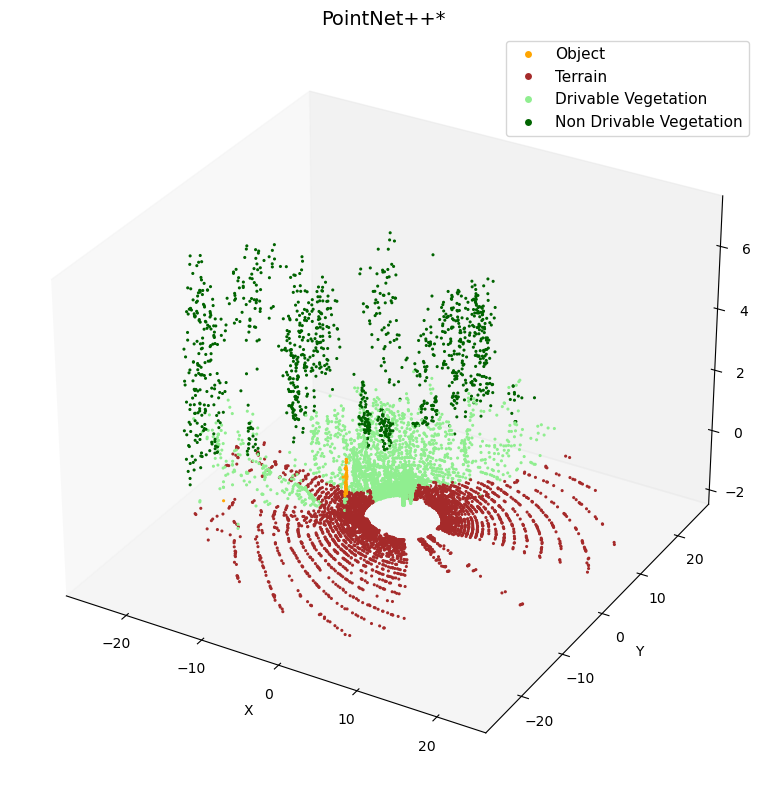

In [187]:
visualizar_prediccion_matplotlib(all_points, all_preds, indice=0, color_map=color_mapping_2, class_labels=class_labels_2)


Distribución de clases reales:
Clase 1: 835 puntos
Clase 4: 17403 puntos
Clase 5: 16573 puntos
Clase 6: 17442 puntos
Clase 8: 78819 puntos


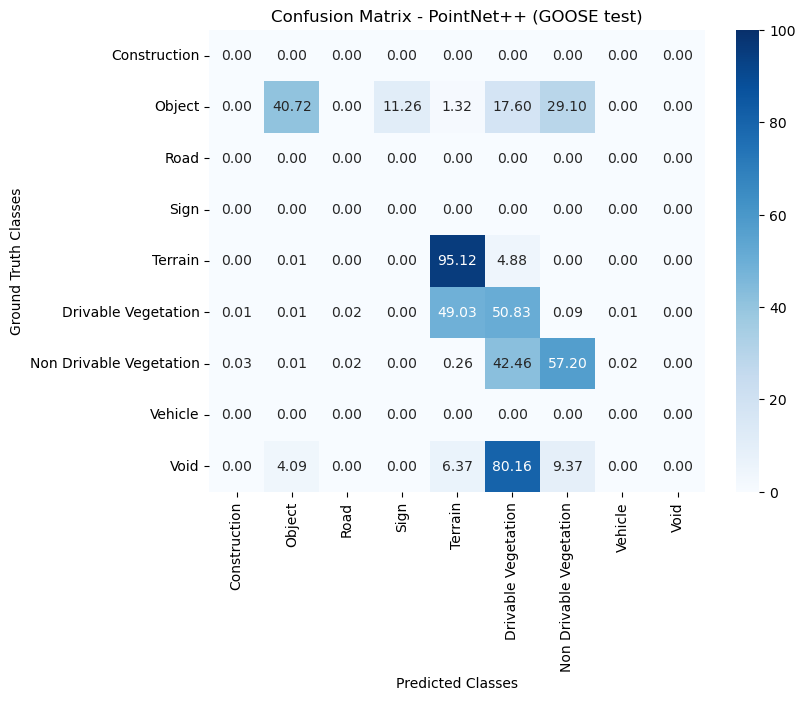

In [181]:
plot_confusion_matrix_percentage(all_labels, all_preds, num_classes=9)


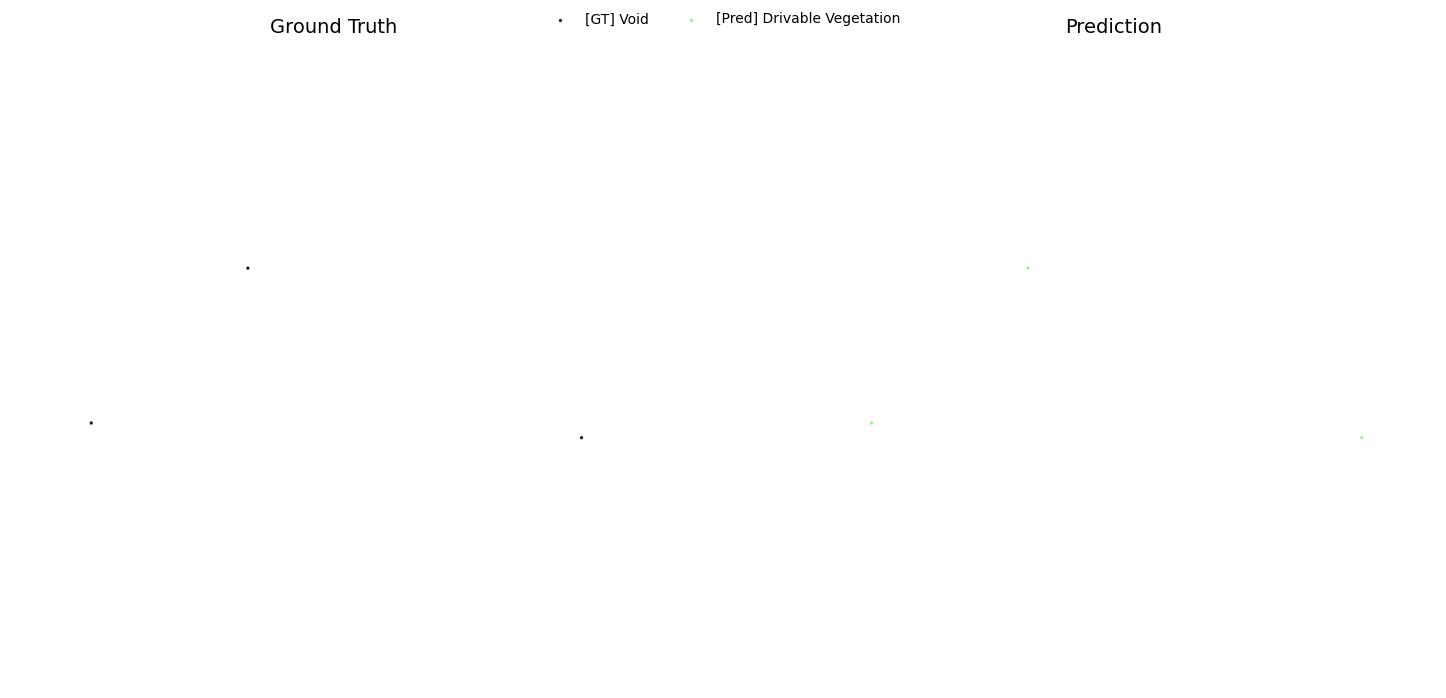

In [120]:
visualizar_comparacion_matplotlib(all_points, all_labels, all_preds, indice=3, color_map=color_mapping_2, class_labels=class_labels_2)

In [113]:
import numpy as np

# Flatten para comparar punto a punto
all_preds = all_preds.flatten()
all_labels = all_labels.flatten()

accuracy = np.mean(all_preds == all_labels)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 26.23%


In [135]:
from sklearn.metrics import confusion_matrix
import numpy as np

# all_labels: etiquetas reales (1D array)
# all_preds: etiquetas predichas (1D array)
num_classes = np.max(all_labels) + 1  # O usa un valor fijo si lo prefieres

# Matriz de confusión
conf_matrix = confusion_matrix(all_labels, all_preds, labels=range(num_classes))

# Intersección y unión para IoU
intersection = np.diag(conf_matrix)
union = conf_matrix.sum(axis=1) + conf_matrix.sum(axis=0) - intersection
iou_per_class = intersection / np.maximum(union, 1e-6)
miou = np.mean(iou_per_class)

# Accuracy global
total_correct = np.trace(conf_matrix)
total_points = np.sum(conf_matrix)
overall_accuracy = total_correct / total_points

# Accuracy por clase (recall por clase)
class_accuracy = intersection / np.maximum(conf_matrix.sum(axis=1), 1e-6)

# Mostrar resultados
print(f"Global Accuracy: {overall_accuracy * 100:.2f}%")
print(f"Mean IoU: {miou * 100:.2f}%\n")

for i in range(num_classes):
    print(f"Class {i} - IoU: {iou_per_class[i] * 100:.2f}%, Accuracy: {class_accuracy[i] * 100:.2f}%")


Global Accuracy: 26.23%
Mean IoU: 13.49%

Class 0 - IoU: 0.00%, Accuracy: 0.00%
Class 1 - IoU: 32.98%, Accuracy: 60.36%
Class 2 - IoU: 0.00%, Accuracy: 0.00%
Class 3 - IoU: 0.00%, Accuracy: 0.00%
Class 4 - IoU: 32.77%, Accuracy: 97.49%
Class 5 - IoU: 10.78%, Accuracy: 46.65%
Class 6 - IoU: 44.87%, Accuracy: 52.60%
Class 7 - IoU: 0.00%, Accuracy: 0.00%
Class 8 - IoU: 0.00%, Accuracy: 0.00%
